In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
from matplotlib import animation
from matplotlib.animation import PillowWriter

%matplotlib inline
%config InlineBackend.figure_format='retina'
#!pip install git+https://github.com/M-Bianchi/My_matplotlib_style
plt.style.use('mystyle')

# Extract Data

In [2]:
name = '10k_b0.1'

theta = 0.05
eps = 0.0075

M = 1        
b = 0.1

One can decide whether to extract time, positions and velocities from the `.out` file or to import the data from previously-saved numpy arrays.

In [3]:
import_from_saved_nparrays = True
save_arrays = False

# Import the data from previously-saved numpy arrays...
if import_from_saved_nparrays:
    time = np.load('numpy_arrays/'+name+'_time.npy')
    x = np.load('numpy_arrays/'+name+'_x.npy')
    y = np.load('numpy_arrays/'+name+'_y.npy')
    z = np.load('numpy_arrays/'+name+'_z.npy')
    vx = np.load('numpy_arrays/'+name+'_vx.npy')
    vy = np.load('numpy_arrays/'+name+'_vy.npy')
    vz = np.load('numpy_arrays/'+name+'_vz.npy')
    N = int(len(x[:,0]))

    print(f'This is the data of {N} particles at {len(time)} time intervals')
    
    
# or extract it from the '.out' file
else:
    # Extract the data by reading one line of the file at a time
    extension = '.out'

    file = open('./plummer_'+name+extension, 'r')

    N = int(file.readline())
    time = []
    x = []
    y = []
    z = []
    vx = []
    vy = []
    vz = []

    step = 3 + 3*N
    i = 1
    j = 0

    while(True):   
        line = file.readline()

        if line=='':
            file.close()
            break
        
        i += 1

        k = i-j*step
        if (k==3): time.append(float(line))
        elif (k > 3+N and k <= 3+2*N): 
            line = [float(x) for x in line.split()]
            x.append(line[0])
            y.append(line[1])
            z.append(line[2])
        elif (k > 3+2*N and k <= 3+3*N):
            line = [float(x) for x in line.split()]
            vx.append(line[0])
            vy.append(line[1])
            vz.append(line[2])

        if i%step==0: j += 1
        
    # Convert the data from lists to numpy arrays 
    time = np.array(time)
    x = np.array(x).reshape(len(time), N).T
    y = np.array(y).reshape(len(time), N).T
    z = np.array(z).reshape(len(time), N).T
    vx = np.array(vx).reshape(len(time), N).T
    vy = np.array(vy).reshape(len(time), N).T
    vz = np.array(vz).reshape(len(time), N).T

    print(f'This is the data of {N} particles at {len(time)} time intervals')
    
    
    # If you want, you can save the data in form of numpy arrays
    if save_arrays:
        np.save('numpy_arrays/'+name+'_time.npy', time)
        np.save('numpy_arrays/'+name+'_x.npy', x)
        np.save('numpy_arrays/'+name+'_y.npy', y)
        np.save('numpy_arrays/'+name+'_z.npy', z)
        np.save('numpy_arrays/'+name+'_vx.npy', vx)
        np.save('numpy_arrays/'+name+'_vy.npy', vy)
        np.save('numpy_arrays/'+name+'_vz.npy', vz)

This is the data of 10000 particles at 251 time intervals


# Motion of the CM

Plot the evolution of the center of mass as a function of time

$$\vec{R}_{CM} (t) = \dfrac{\sum_{i=1}^{N} m_i \vec{r}_i(t)}{\sum_{i=1}^{N} m_i} = \dfrac{m_i \sum_{i=1}^{N} \vec{r}_i(t)}{N m_i} = \dfrac{\sum_{i=1}^{N} \vec{r}_i(t)}{N}$$

In [4]:
CMpos_vector = np.array([np.sum(x, axis=0), np.sum(y, axis=0), np.sum(z, axis=0)])/N
CMpos = np.linalg.norm(CMpos_vector, axis=0)

Text(0, 0.5, 'Distance of the CM from the origin [iu]')

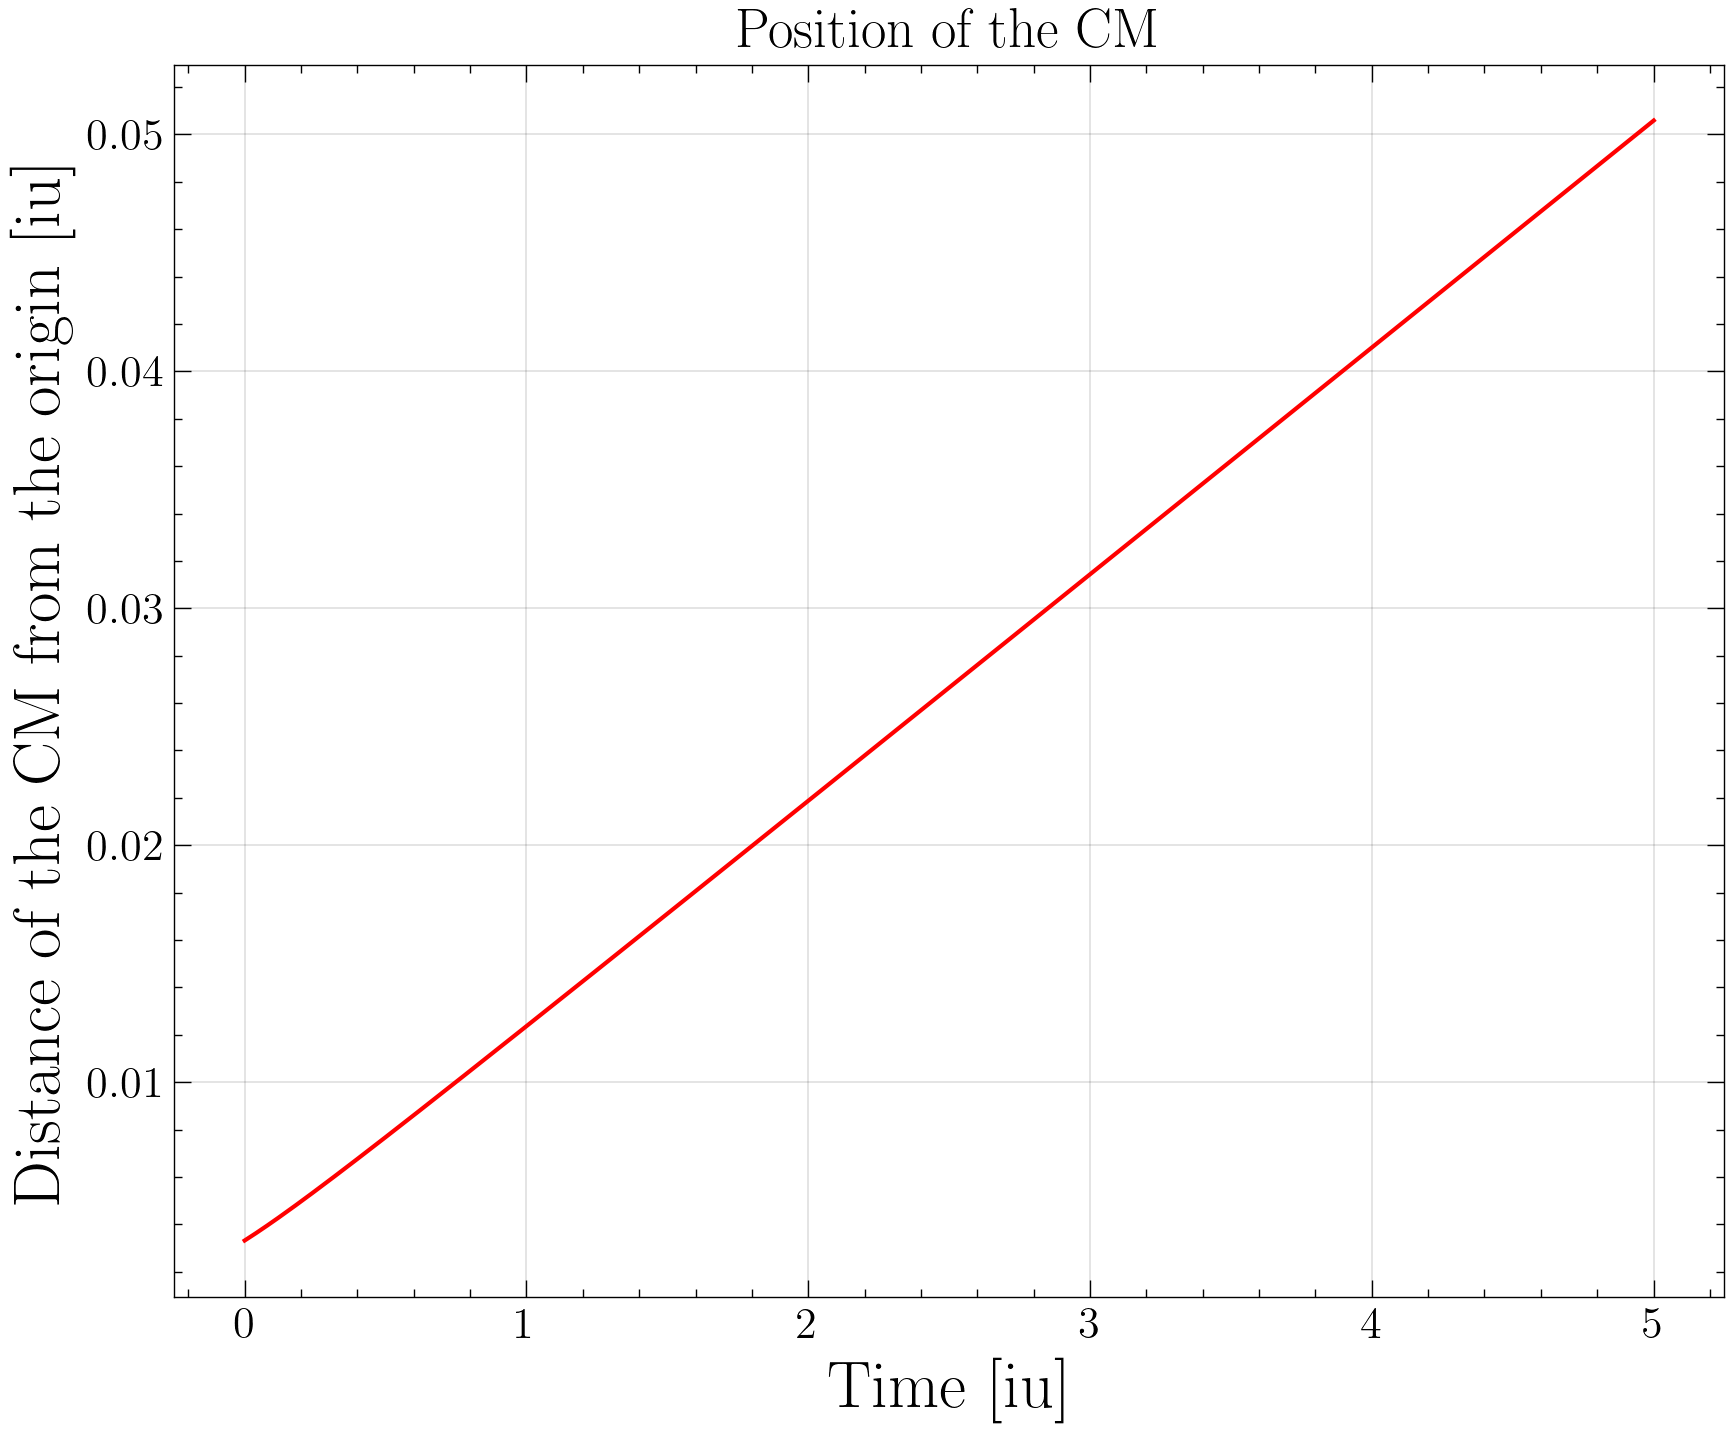

In [5]:
plt.plot(time, CMpos, color='red')
plt.title('Position of the CM', fontsize=20)
plt.xlabel('Time [iu]')
plt.ylabel('Distance of the CM from the origin [iu]')

Compute the distance of each particle from the center of mass at each time

In [6]:
def Dist(x1, y1, z1, x2, y2, z2):
    return np.linalg.norm(np.array([x1-x2, y1-y2, z1-z2]), axis=0)

dist_particle = Dist(x, y, z, CMpos_vector[0], CMpos_vector[1], CMpos_vector[2])
print(dist_particle.shape)

(10000, 251)


We constrain our plots to boxes of length `dist_plotlimits` in each direction, which is defined as the maximum in time of the 90%-quantiles of the distances between the particles and the CM

In [7]:
dist_plotlimits = np.max(np.quantile(dist_particle, 0.9, axis=0))
dist_plotlimits

0.38905362096438567

In [8]:
CMpos_vector_upto90q = np.array([np.sum(x[dist_particle[:,-1]<dist_plotlimits], axis=0), 
                                 np.sum(y[dist_particle[:,-1]<dist_plotlimits], axis=0), 
                                 np.sum(z[dist_particle[:,-1]<dist_plotlimits], axis=0)])/np.sum([dist_particle[:,-1]<dist_plotlimits])
CMpos_upto90q = np.linalg.norm(CMpos_vector_upto90q, axis=0)

Text(0, 0.5, 'Distance of the CM from the origin [iu]')

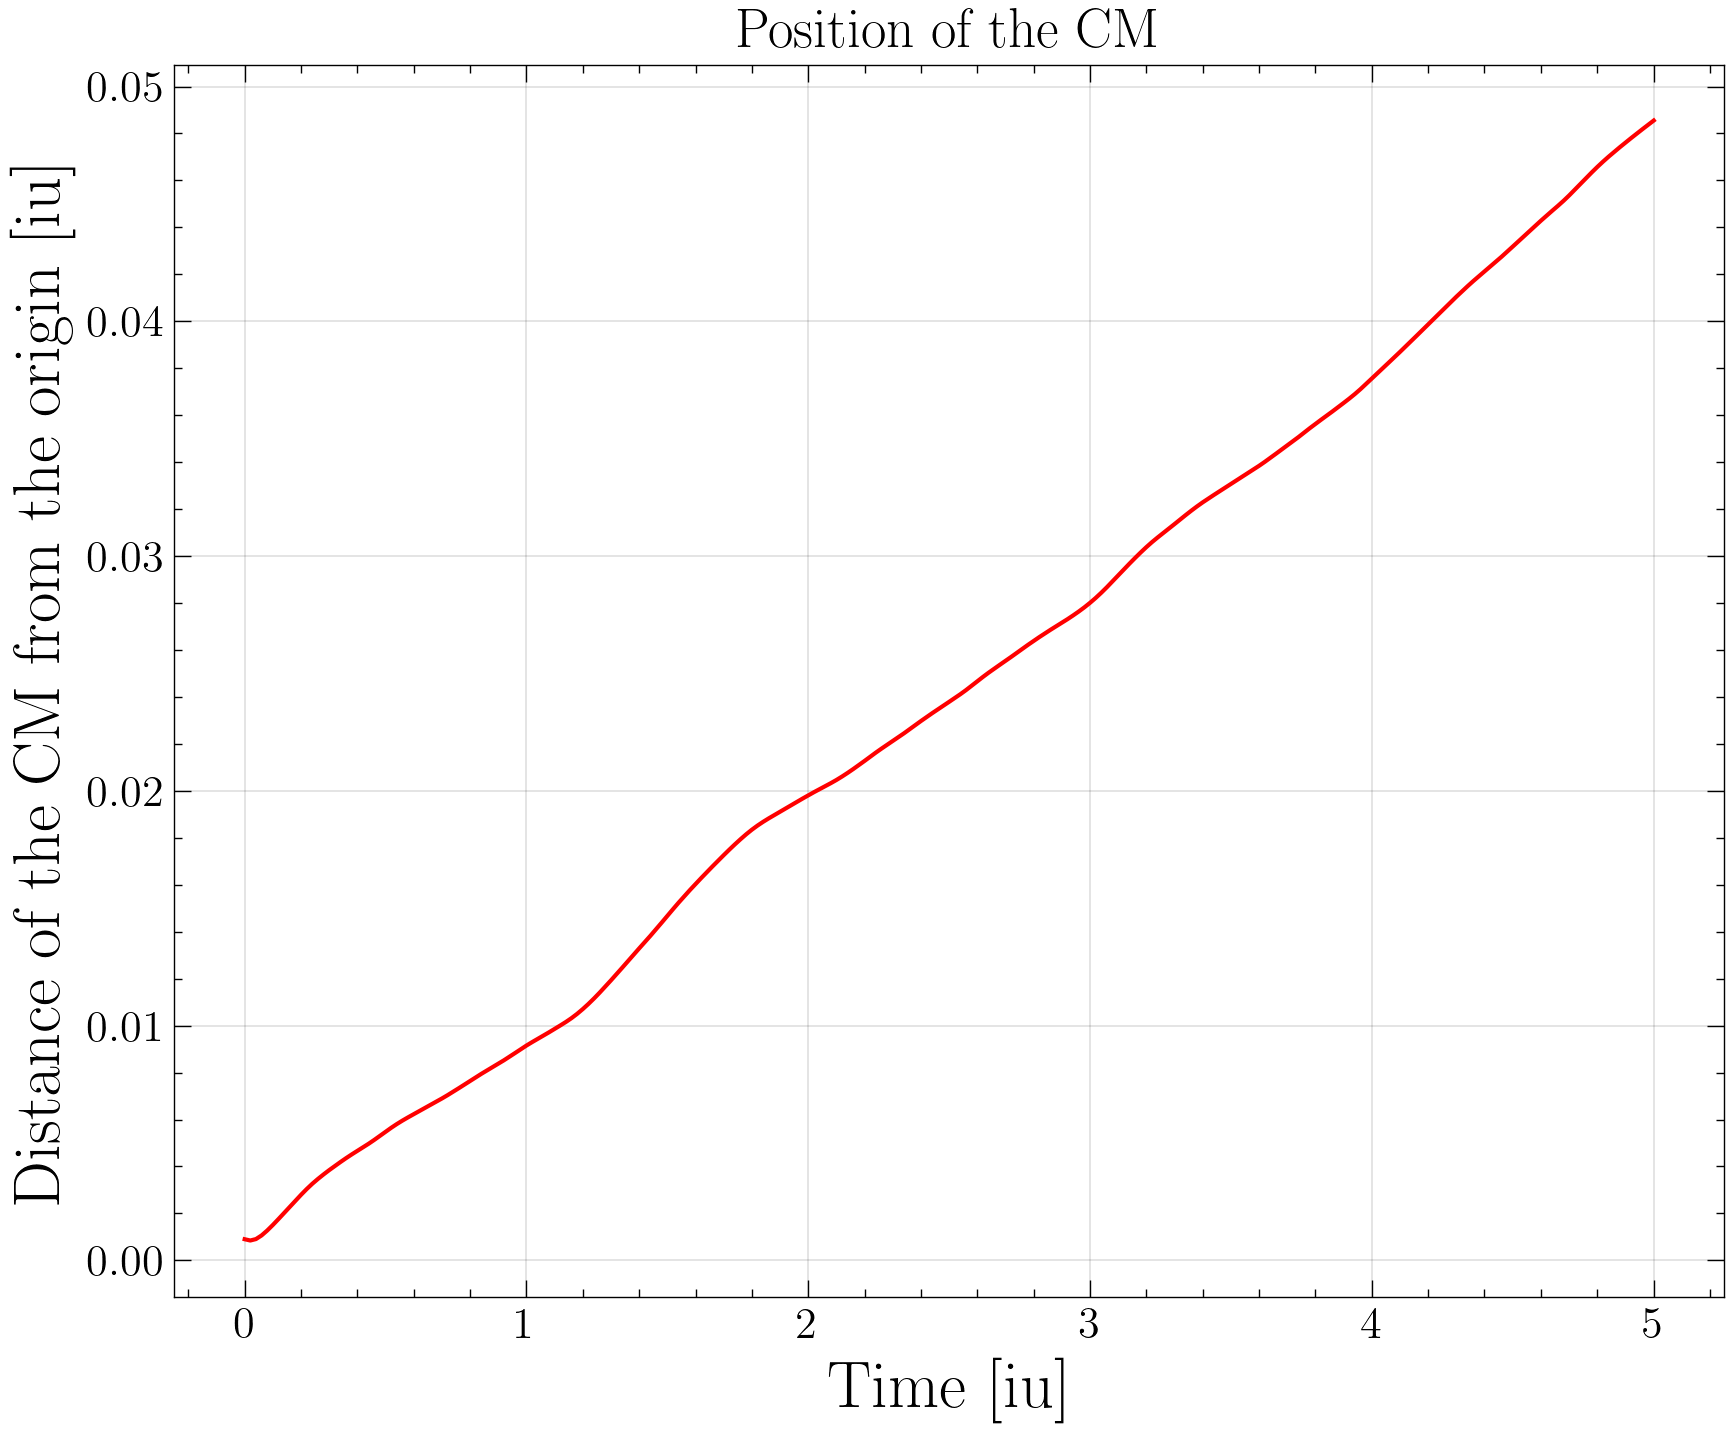

In [9]:
plt.plot(time, CMpos_upto90q, color='red')
plt.title('Position of the CM', fontsize=20)
plt.xlabel('Time [iu]')
plt.ylabel('Distance of the CM from the origin [iu]')

Plot a 2D-histogram of the distribution of particles

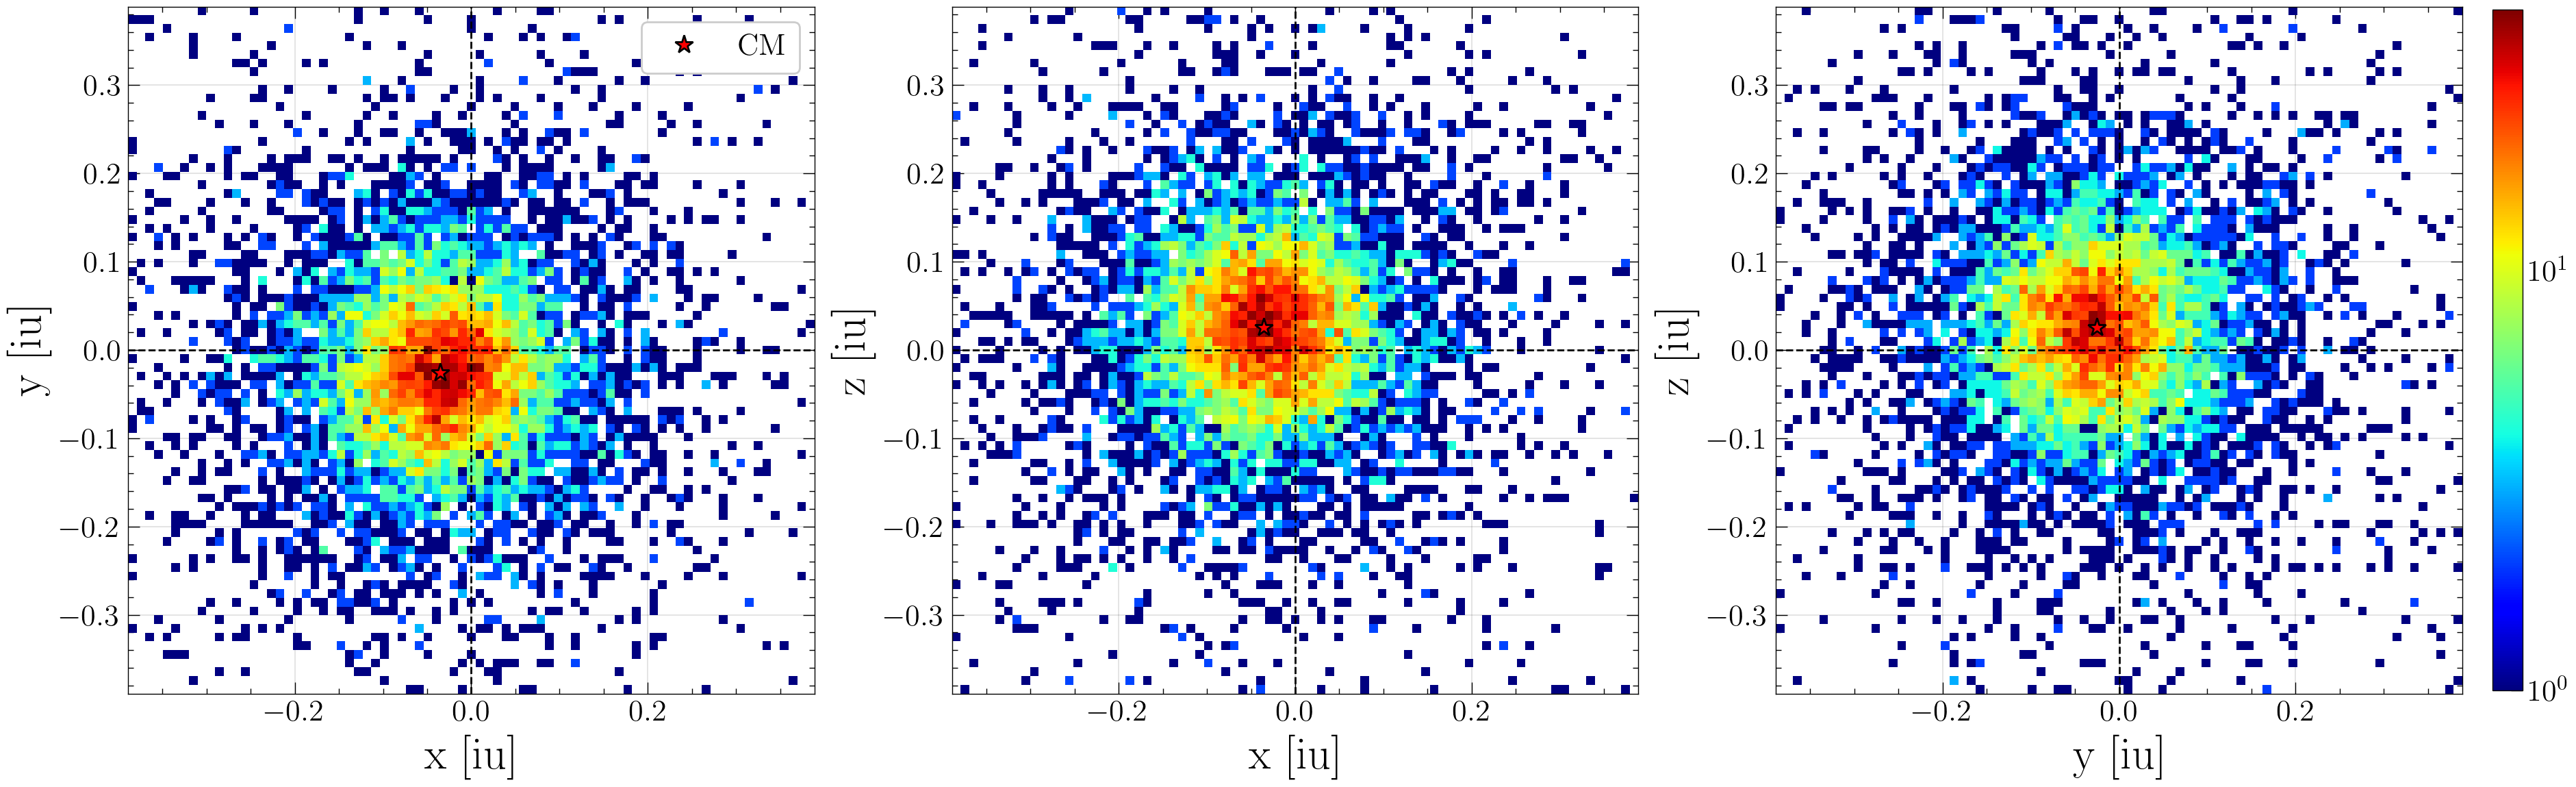

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(22, 7))

nbins = int(20*np.log10(N))
bins = np.linspace(-dist_plotlimits, dist_plotlimits, nbins)
time_index = -1

ax = axes[0]
ax.set_box_aspect(1)
ax.hist2d(x[:, time_index], y[:, time_index], bins=bins, norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet)
ax.axvline(0, ls='--', lw=1,color='black')
ax.axhline(0, ls='--', lw=1,color='black')
ax.plot(CMpos_vector[0, time_index], CMpos_vector[1, time_index], '*', color='red', markeredgewidth=1, markeredgecolor='black', markersize=10, label='CM')
ax.set_xlim(-dist_plotlimits,dist_plotlimits)
ax.set_ylim(-dist_plotlimits,dist_plotlimits)
ax.set_xlabel('x [iu]')
ax.set_ylabel('y [iu]')
ax.legend()

ax = axes[1]
ax.set_box_aspect(1)
ax.hist2d(x[:, time_index], z[:, time_index], bins=bins, norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet)
ax.axvline(0, ls='--', lw=1,color='black')
ax.axhline(0, ls='--', lw=1,color='black')
ax.plot(CMpos_vector[0, time_index], CMpos_vector[2, time_index], '*', color='red', markeredgewidth=1, markeredgecolor='black', markersize=10, label='CM')
ax.set_xlim(-dist_plotlimits,dist_plotlimits)
ax.set_ylim(-dist_plotlimits,dist_plotlimits)
ax.set_xlabel('x [iu]')
ax.set_ylabel('z [iu]')

ax = axes[2]
ax.set_box_aspect(1)
hist = ax.hist2d(y[:, time_index], z[:, time_index], bins=bins, norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet)
ax.axvline(0, ls='--', lw=1,color='black')
ax.axhline(0, ls='--', lw=1,color='black')
ax.plot(CMpos_vector[1, time_index], CMpos_vector[2, time_index], '*', color='red', markeredgewidth=1, markeredgecolor='black', markersize=10, label='CM')
ax.set_xlim(-dist_plotlimits,dist_plotlimits)
ax.set_ylim(-dist_plotlimits,dist_plotlimits)
ax.set_xlabel('y [iu]')
ax.set_ylabel('z [iu]')
cax = fig.add_axes([0.91, 0.14, 0.01, 0.71], label='$N_{points}/bin$')
fig.colorbar(hist[3], cax);

In [11]:
animate_cm = False
if animate_cm:
    # if len(x)=N, then the animation will have N/k frames
    k = 1
    
    fig, axes = plt.subplots(1, 3, figsize=(22, 7))
    title = fig.suptitle(f'{N} particles , b = ${b}$ , $\\theta = {theta:.2f}$ , eps = ${eps:.3f}$ , t = ${time[0]:.2f}$ iu', fontsize=20, y=0.95)   
    
    def animate(i):
        print(math.ceil(100*i*k/len(x[0, :])), "%", end='\r')
        
        title.set_text(f'{N} particles , b = ${b}$ , $\\theta = {theta:.2f}$ , eps = ${eps:.3f}$ , t = ${time[k*i]:.2f}$ iu')
        
        ax = axes[0]
        ax.clear()
        ax.set_box_aspect(1)
        ax.hist2d(x[:, k*i], y[:, k*i], bins=bins, norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet)
        ax.axvline(0, ls='--', lw=1,color='black')
        ax.axhline(0, ls='--', lw=1,color='black')
        ax.plot(CMpos_vector[0, k*i], CMpos_vector[1, k*i], '*', color='red', markeredgewidth=1, markeredgecolor='black', markersize=10, label='CM')
        ax.set_xlim(-dist_plotlimits,dist_plotlimits)
        ax.set_ylim(-dist_plotlimits,dist_plotlimits)
        ax.set_xlabel('x [iu]')
        ax.set_ylabel('y [iu]')
        ax.legend()
    
        ax = axes[1]
        ax.clear()
        ax.set_box_aspect(1)
        ax.hist2d(x[:, k*i], z[:, k*i], bins=bins, norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet)
        ax.axvline(0, ls='--', lw=1,color='black')
        ax.axhline(0, ls='--', lw=1,color='black')
        ax.plot(CMpos_vector[0, k*i], CMpos_vector[2, k*i], '*', color='red', markeredgewidth=1, markeredgecolor='black', markersize=10, label='CM')
        ax.set_xlim(-dist_plotlimits,dist_plotlimits)
        ax.set_ylim(-dist_plotlimits,dist_plotlimits)
        ax.set_xlabel('x [iu]')
        ax.set_ylabel('z [iu]')
    
        ax = axes[2]
        ax.clear()
        ax.set_box_aspect(1)
        ax.hist2d(y[:, k*i], z[:, k*i], bins=bins, norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet)
        ax.axvline(0, ls='--', lw=1,color='black')
        ax.axhline(0, ls='--', lw=1,color='black')
        ax.plot(CMpos_vector[1, k*i], CMpos_vector[2, k*i], '*', color='red', markeredgewidth=1, markeredgecolor='black', markersize=10, label='CM')
        ax.set_xlim(-dist_plotlimits,dist_plotlimits)
        ax.set_ylim(-dist_plotlimits,dist_plotlimits)
        ax.set_xlabel('y [iu]')
        ax.set_ylabel('z [iu]')
        
        if i==0:
            cax = fig.add_axes([0.91, 0.14, 0.01, 0.71], label='$N_{points}/bin$')
            fig.colorbar(hist[3], cax);
            
        return fig,
    
    writer = animation.FFMpegWriter(fps=60)
    ani = animation.FuncAnimation(fig, animate, frames=int(len(x[0, :])/k), interval=1, blit=True)
    ani.save('cm_evolution.gif', writer=writer, dpi=100)

# Animation

In [12]:
markersize = 4
markeredgewidth = 0.15

In [13]:
animate_distribution = False

if animate_distribution:
    # if len(x)=N, then the animation will have N/k frames
    k = 1
    
    #fig = plt.Figure() #somehow faster than fig, ax = plt.subplots(1,1), but text doesn't work well
    #ax = fig.add_subplot()
    fig, axes = plt.subplots(1, 1, subplot_kw={'projection':'3d'}, figsize=(20, 20))
    ax = axes
    title = fig.suptitle(f'{N} particles , b = ${b}$ , $\\theta = {theta:.2f}$ , eps = ${eps:.3f}$ , t = ${time[0]:.2f}$ iu', fontsize=30, y=0.92)
    
    def animate(i):
        print(f'frame {(i+1)}/{int(len(x[0])/k)}, {math.ceil(100*i*k/len(x[0]))}%', end='\r')
        
        ax.clear()
        ax.set_box_aspect([1, 1, 1])
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.set_xlim(-dist_plotlimits, dist_plotlimits)
        ax.set_ylim(-dist_plotlimits, dist_plotlimits)
        ax.set_zlim(-dist_plotlimits, dist_plotlimits)
        title.set_text(f'{N} particles , b = ${b}$ , $\\theta = {theta:.2f}$ , eps = ${eps:.3f}$ , t = ${time[k*i]:.2f}$ iu')
        #ax.view_init(elev=30, azim=0.3*i)
        
        for j in range(len(x[:,])):
            dist = Dist(x[j, 0], y[j, 0], z[j, 0], CMpos_vector[0,0], CMpos_vector[1,0], CMpos_vector[2,0])
            #if  j==4: ax.plot3D(x[j, k*i], y[j, k*i], z[j, k*i], 'o', markersize=6*markersize, markeredgecolor='black', markeredgewidth=markeredgewidth, color='red')
            if  dist > 0.66*dist_plotlimits: ax.plot3D(x[j, k*i], y[j, k*i], z[j, k*i], 'o', markersize=2*markersize, markeredgecolor='black', markeredgewidth=markeredgewidth, color='deepskyblue', alpha=0.7)
            elif (dist < 0.66*dist_plotlimits and dist > 0.33*dist_plotlimits): ax.plot3D(x[j, k*i], y[j, k*i], z[j, k*i], 'o', markersize=2*markersize, markeredgecolor='black', markeredgewidth=markeredgewidth, color='lightgreen', alpha=0.7)
            else : ax.plot3D(x[j, k*i], y[j, k*i], z[j, k*i], 'o', markersize=2*markersize, markeredgecolor='black', markeredgewidth=markeredgewidth, color='orange', alpha=0.7)
        return fig,
    
    writer = animation.FFMpegWriter(fps=60)
    ani = animation.FuncAnimation(fig, animate, frames=int(len(x[0])/k), interval=1, blit=True)
    ani.save('plummer.gif', writer=writer, dpi=100)
    
    #ani.save('plummer.mp4', writer=animation.FFMpegWriter(fps=40, bitrate=5000, codec='h264'), dpi=50)

# Radial and velocity distribution as a function of time

In [14]:
# Define radial bins
r_bins = np.linspace(0, np.max(np.quantile(dist_particle, 0.995, axis=0)), 40)

# Compute histogram of radial distances
hist_dist = np.zeros([len(r_bins)-1, len(dist_particle[0, :])])
for i in range(len(dist_particle[0, :])):
    hist_dist[:, i] = np.histogram(dist_particle[:, i], bins=r_bins)[0]

In [ ]:
v_particle = np.sqrt(vx**2+vy**2+vz**2)

# Define velocity bins
v_bins = np.linspace(0, np.max(np.quantile(v_particle, 0.995, axis=0)), 40)

# Compute histogram of velocities
hist_v = np.zeros([len(v_bins)-1, len(v_particle[0, :])])
for i in range(len(v_particle[0, :])):
    hist_v[:, i] = np.histogram(v_particle[:, i], bins=v_bins)[0]

In [16]:
def Plot_Hists(t, r_bins, v_bins):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Histogram of the radial positions
    hist_dist_plot = hist_dist[:, t]
    
    ax = axes[0]
    ax.bar(r_bins[:-1], hist_dist_plot, width=np.diff(r_bins), color='lightblue', edgecolor="black", align="edge", label='Data')
    ax.plot(r_bins, np.sum(np.diff(r_bins)*hist_dist_plot) * (3*r_bins**2/b**3)*(1+r_bins**2/b**2)**(-5/2), color='red', label='Pdf(r)')
    ax.axvline(b, ls='--', color='black', label='r=b')
    ax.set_yscale('log')
    ax.set_ylim(bottom=1)
    ax.set_xlabel('Radial distance $[iu]$')
    ax.set_ylabel('Number of particles')
    ax.legend(loc='upper right')
    
    
    # Histogram of the velocities
    hist_v_plot = hist_v[:, t]
    
    ax = axes[1]
    ax.bar(v_bins[:-1], hist_v_plot, width=np.diff(v_bins), color='lightblue', edgecolor="black", align="edge")
    ax.set_xlabel('Velocity $[iu$')
    ax.set_ylim(0, np.max(hist_v))
    
    return fig, axes

In [17]:
animate_hist = False

if animate_hist:
    # if len(x)=N, then the animation will have N/k frames
    k = 1
    
    fig, axes = plt.subplots(1, 2, figsize=(16,8))
    ax = axes
    title = fig.suptitle(f'{N} particles , b = ${b}$ , $\\theta = {theta:.2f}$ , eps = ${eps:.3f}$ , t = ${time[0]:.2f}$ iu', fontsize=20, y=0.95)
    
    def animate(i):
        print(math.ceil(100*i*k/len(hist_dist[0, :])), "%", end='\r')
        
        title.set_text(f'{N} particles , b = ${b}$ , $\\theta = {theta:.2f}$ , eps = ${eps:.3f}$ , t = ${time[k*i]:.2f}$ iu')
        
        # Histogram of the radial positions
        hist_dist_plot = hist_dist[:, k*i]

        ax = axes[0]
        ax.clear()
        ax.bar(r_bins[:-1], hist_dist_plot, width=np.diff(r_bins), color='lightblue', edgecolor="royalblue", align="edge", label='Data')
        ax.plot(r_bins, np.sum(np.diff(r_bins)*hist_dist_plot) * (3*r_bins**2/b**3)*(1+r_bins**2/b**2)**(-5/2), color='red', label='Pdf(r)')
        ax.axvline(b, ls='--', color='black', label='r=b')
        ax.set_xlim(0)
        ax.set_yscale('log')
        ax.set_ylim(1, 1.05*np.max(hist_dist))
        ax.set_xlabel('Radial distance $[iu]$')
        ax.set_ylabel('Number of particles')
        ax.legend(loc='upper right')
        
        
        # Histogram of the velocities
        hist_v_plot = hist_v[:, k*i]

        ax = axes[1]
        ax.clear()
        ax.bar(v_bins[:-1], hist_v[:, 0], width=np.diff(v_bins), color='white', edgecolor="red", align="edge")
        ax.bar(v_bins[:-1], hist_v_plot, width=np.diff(v_bins), color='lightblue', edgecolor="royalblue", align="edge")
        ax.set_xlim(0)
        ax.set_xlabel('Velocity $[iu]$')
        ax.set_ylim(0, 1.05*np.max(hist_v))
            
        return fig,
    
    writer = animation.FFMpegWriter(fps=60)
    ani = animation.FuncAnimation(fig, animate, frames=int(len(hist_dist[0, :])/k), interval=1, blit=True)
    ani.save('histogram.gif', writer=writer, dpi=100)

# Distance quantiles

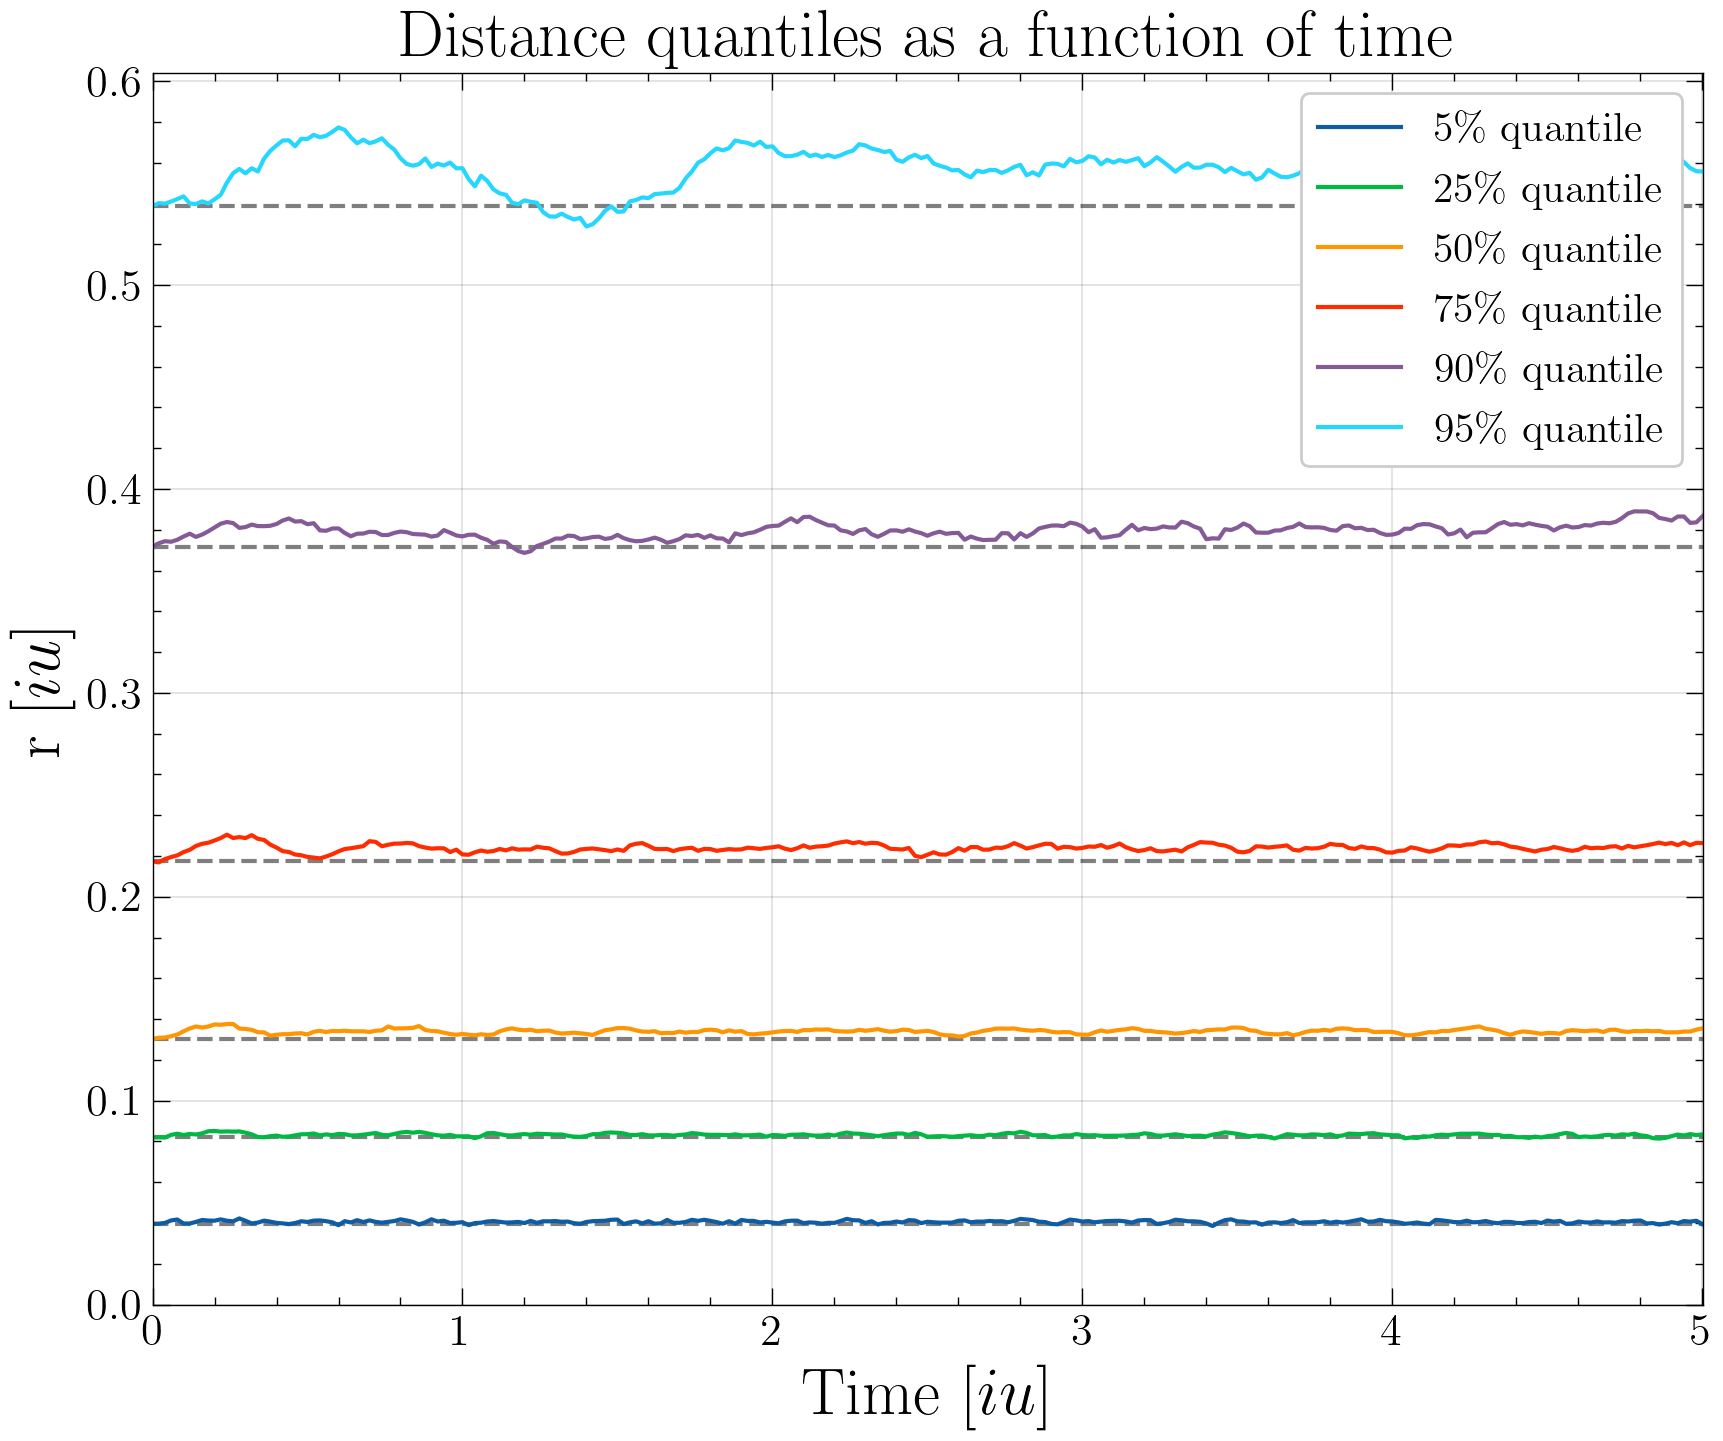

In [18]:
quantiles = [0.05, 0.25, 0.5, 0.75, 0.9, 0.95]
dist_quantiles = np.quantile(dist_particle, quantiles, axis=0)
for i in range(len(quantiles)):
    plt.axhline(dist_quantiles[i][0], ls='--', color='black', alpha=0.5)
    plt.plot(time, dist_quantiles[i], label=f'{int(100*quantiles[i])}\% quantile')
plt.xlim(0, time[-1])
plt.ylim(0)
plt.title('Distance quantiles as a function of time')
plt.xlabel('Time $[iu]$')
plt.ylabel('r $[iu]$')
plt.legend(loc='upper right', fontsize=15);

# Density profile

In [19]:
r_bins_rho = r_bins[:-1] + np.diff(r_bins)

rho = np.ones([len(r_bins_rho), len(time)])
for i in range(len(r_bins_rho)):
    volume = (4*np.pi/3)*r_bins_rho[i]**3
    rho[i,:] = (M/N)*np.sum(dist_particle<r_bins_rho[i], axis=0)/volume

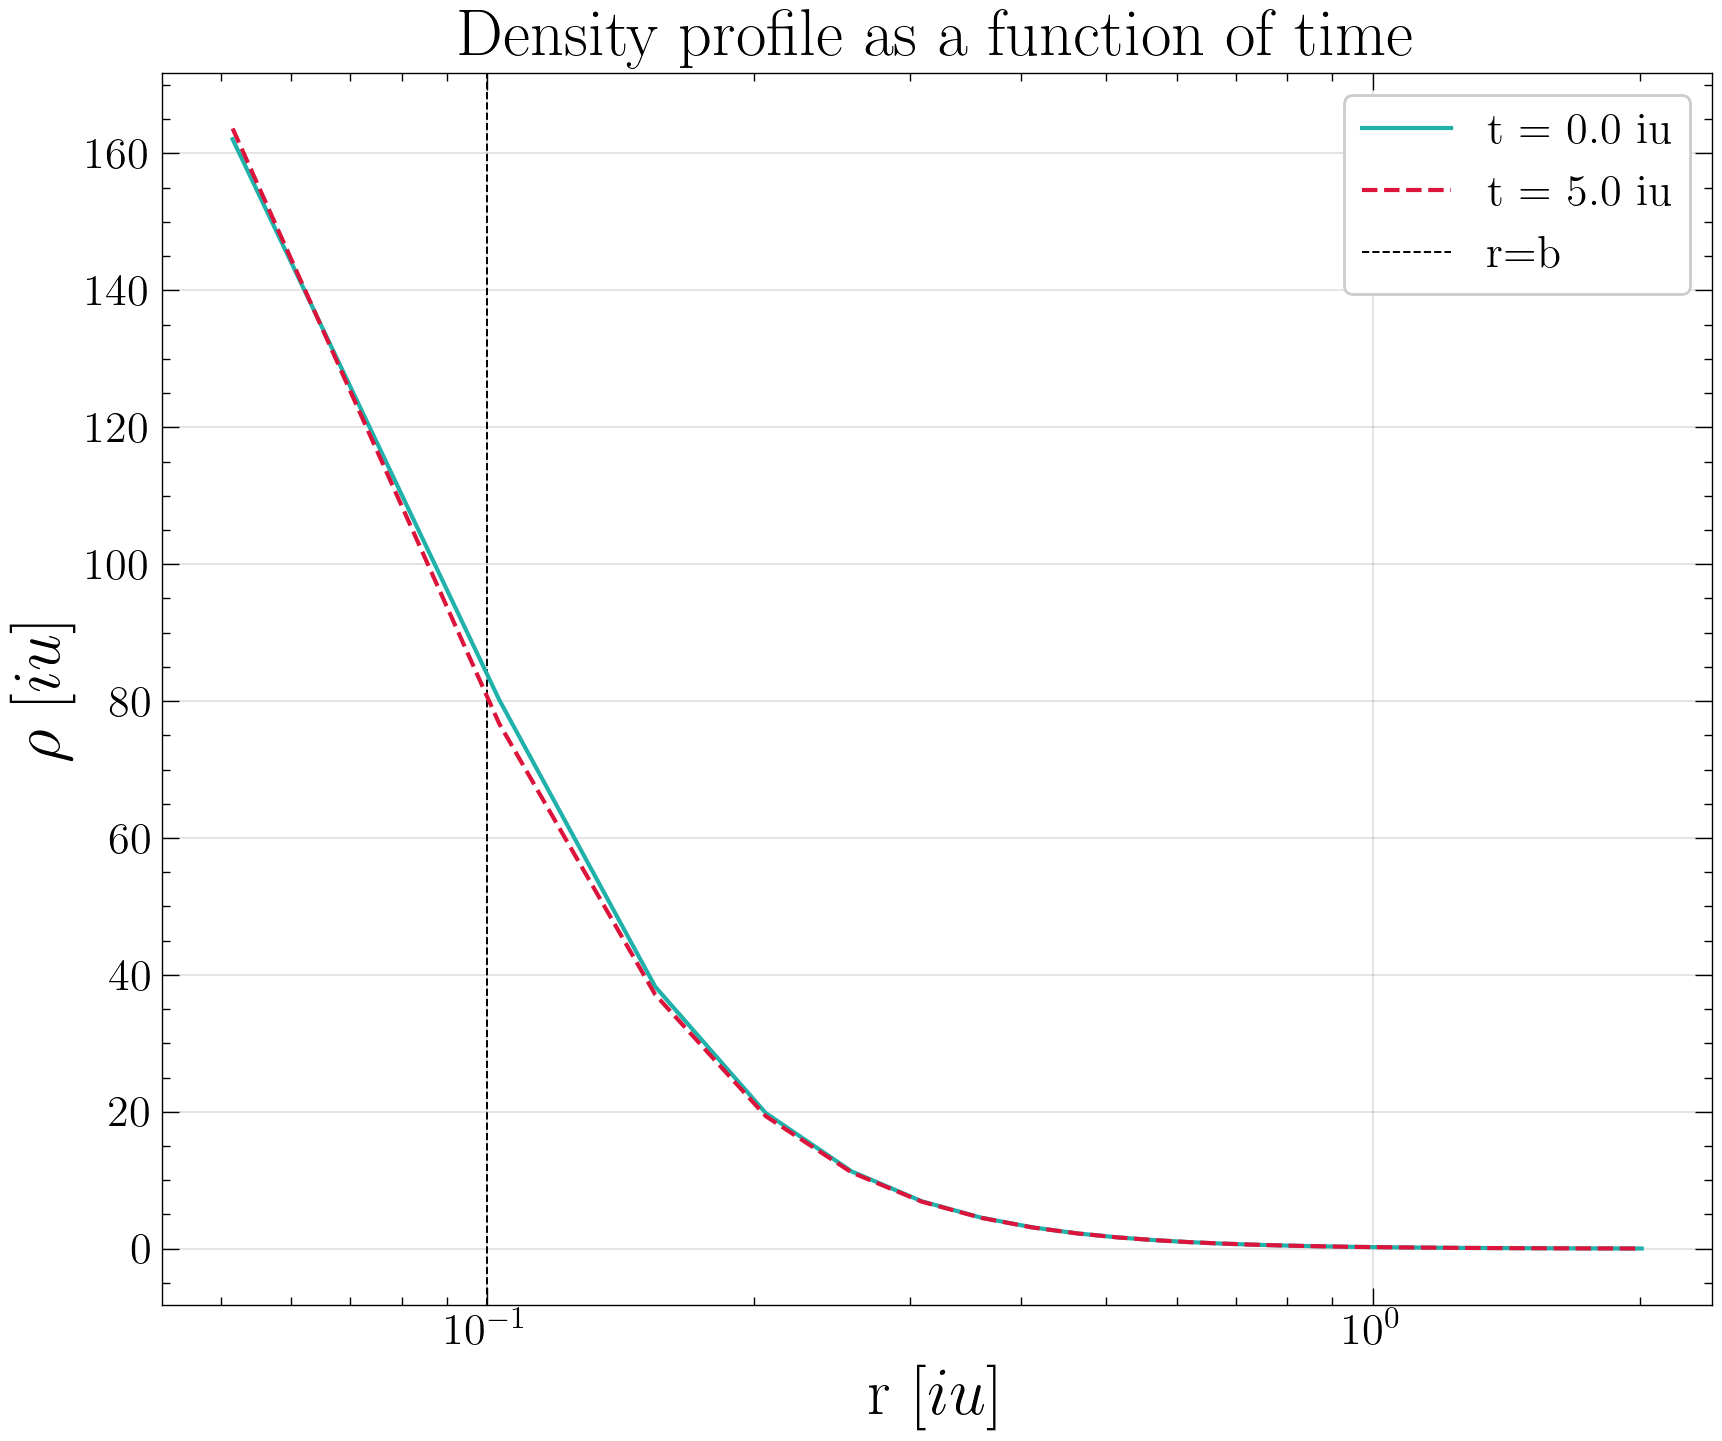

In [20]:
plt.plot(r_bins_rho, rho[:,0], color='lightseagreen', label=f't = {time[0]:.1f} iu')
plt.plot(r_bins_rho, rho[:,-1], color='crimson', ls='--', label=f't = {time[-1]:.1f} iu')
plt.axvline(b, color='black', ls='--', lw=0.7, label='r=b', zorder=0)
plt.xscale('log')
plt.title('Density profile as a function of time')
plt.xlabel('r $[iu]$')
plt.ylabel('$\\rho$ $[iu]$')
plt.legend();